# Time series analysis

- Monthly data from ERA-INTERIM.
- Methodology for anomalies decomposition.
- Testing unit roots for all pixels in South America.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy import stats
from dask.diagnostics import ProgressBar

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler, RobustScaler

%matplotlib inline

In [4]:
print(">>> Version of xarray:", xr.__version__)

>>> Version of xarray: 0.14.0


In [5]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [6]:
# Folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/ERA_INTERIM/total_precipitation_mmeans/"

In [7]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## Load data

In [8]:
%%time

# List files.
FILES_MMEANS = sorted(glob.glob(DATA_FOLDER + "*.grb"))

# DataSets objects.
DS = xr.open_mfdataset(FILES_MMEANS, engine="cfgrib")

# Shift longitudes and guarantee time ordering.
DS = DS.assign_coords(longitude=(DS.longitude + 180) % 360 - 180)
DS = DS.sortby(DS.longitude)
DS = DS.sortby(DS.time)

# South America.
DS = DS.sel(longitude=slice(loni, lonf), latitude=slice(lati, latf))

# Land mask at ERA-INTERIM grid.
DS = cdlearn.pixels.EraInterimGrid.add_land_mask(DS)

DS

CPU times: user 2.08 s, sys: 71.3 ms, total: 2.16 s
Wall time: 2.6 s


<xarray.Dataset>
Dimensions:     (latitude: 107, longitude: 81, time: 480)
Coordinates:
    step        timedelta64[ns] 12:00:00
    surface     int64 0
    number      int64 0
  * latitude    (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * longitude   (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
    valid_time  (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    land_mask   (latitude, longitude) bool True True True ... False False False
Data variables:
    tp          (time, latitude, longitude) float32 dask.array<chunksize=(12, 107, 81), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
  

In [9]:
# Load data into memory.
DA = DS.tp
with ProgressBar():
    DA = DA.compute()

[########################################] | 100% Completed | 10.4s


In [10]:
%%time

# Anomalies.
DA_ano = cdlearn.statistics.anomalies(DA)

# Linear trends and its statistics.
trends, _ = cdlearn.statistics.linear_trends(DA)
linstats = cdlearn.statistics.linear_regression(DA)

# Climatology.
clim = cdlearn.statistics.climatology(DA)

CPU times: user 5.98 s, sys: 316 ms, total: 6.3 s
Wall time: 4.77 s


## Time series decomposition

CPU times: user 469 ms, sys: 11.7 ms, total: 481 ms
Wall time: 323 ms


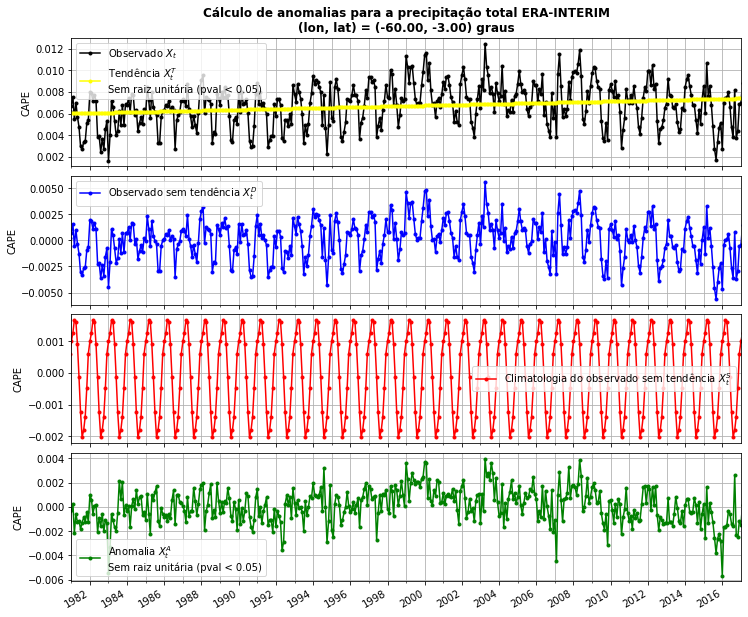

In [11]:
%%time

play = False

lon, lat = np.meshgrid(DA.longitude.values, DA.latitude.values)
lon = lon[DA.land_mask==True]; lat = lat[DA.land_mask==True]

if play:
    
    # Random land pixel.
    selection = {"longitude": np.random.choice(lon),
                 "latitude": np.random.choice(lat),
                 "method": "nearest"}    
    
else:    

    # Select a location around Manaus.
    selection = {"longitude": -60,
                 "latitude": -3,
                 "method": "nearest"}

# Complete and detailed example of anomaly calculation.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 10))

# Observed time series and its trend.
p_val = adfuller(DA.sel(**selection).values)[1]
if p_val <= 0.05:
    state = str("\nSem raiz unitária (pval < 0.05)")
else:
    state = str("\nCom raiz unitária (pval > 0.05)")
DA.sel(**selection).plot(ax=ax1, marker=".", color="black")
trends.sel(**selection).plot(ax=ax1, marker=".", color="yellow")
ax1.set_ylabel("CAPE"); ax1.set_xlabel(""); ax1.set_title("")
ax1.legend([r"Observado $X_t$", r"Tendência $X_t^T$" + state])
ax1.set_title("Cálculo de anomalias para a precipitação total" + \
              " ERA-INTERIM\n" + str("(lon, lat) = (%.2f, %.2f) graus" \
              %(selection["longitude"], selection["latitude"])), weight="bold")

# Detrend data.
(DA - trends).sel(**selection).plot(ax=ax2, marker=".", color="blue")
ax2.set_ylabel("CAPE"); ax2.set_xlabel(""); ax2.set_title("")
ax2.legend([r"Observado sem tendência $X_t^D$"])

# Climatology.
clim.sel(**selection).plot(ax=ax3, marker=".", color="red")
ax3.set_ylabel("CAPE"); ax3.set_xlabel(""); ax3.set_title("")
ax3.legend([r"Climatologia do observado sem tendência $X_t^S$"])

# Anomaly.
p_val = adfuller(DA_ano.sel(**selection).values)[1]
if p_val <= 0.05:
    state = str("\nSem raiz unitária (pval < 0.05)")
else:
    state = str("\nCom raiz unitária (pval > 0.05)")
DA_ano.sel(**selection).plot(ax=ax4, marker=".", color="green")
ax4.set_ylabel("CAPE"); ax4.set_xlabel(""); ax4.set_title("")
ax4.legend([r"Anomalia $X_t^A$" + state])

# Grids and axes.
for ax in [ax1, ax2, ax3, ax4]:
    years = mdates.YearLocator(2)
    years_fmt = mdates.DateFormatter("%Y")
    
    if ax == ax4:
        ax.set_xlim(pd.Timestamp("1981"), pd.Timestamp("2017"))
        ax.set_xticks(pd.date_range(start="1981", end="2016", freq="1YS"), minor=True)
    
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt) 
    ax.grid(which="both")
    
plt.subplots_adjust(hspace=0.075)    

## Testing if data is stationary

In [12]:
%%time

# Augmented Dickey-Fuller unit root test.
ADFs = cdlearn.statistics.unit_root_test(DA)
ADFs_ano = cdlearn.statistics.unit_root_test(DA_ano)

CPU times: user 7min 48s, sys: 5.68 s, total: 7min 53s
Wall time: 3min 58s


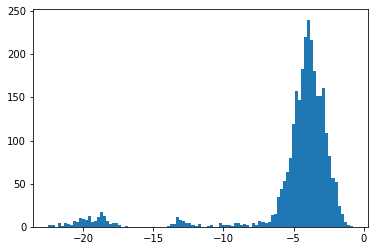

In [17]:
# Sanity check.
plt.hist(
    ADFs.sel(stats="adf_test").where(ADFs.land_mask==True).values.flatten(), 
    bins=100
);

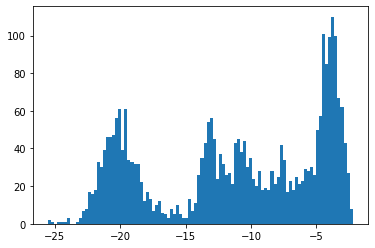

In [18]:

plt.hist(
    ADFs_ano.sel(stats="adf_test").where(ADFs_ano.land_mask==True).values.flatten(), 
    bins=100
);

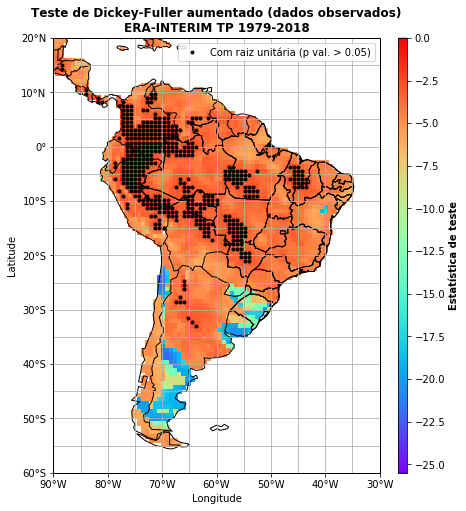

In [19]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    da = ADFs.sel(stats="adf_test").where(ADFs.land_mask == True)
    p = da.plot(
        ax=axis,
        vmin=-25.5,
        vmax=0,
        cmap=plt.cm.rainbow,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Teste de Dickey-Fuller aumentado (dados observados)\n" + \
                     "ERA-INTERIM TP 1979-2018", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Estatística de teste", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-25, 2.5, 2.5))

# Statistical significant trends.
mask = ADFs.sel(stats="p_value").where(ADFs_ano.land_mask == True) > 0.05
LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

# With unit root.
axis.plot(LON[mask], LAT[mask], ".k", label="Com raiz unitária (p val. > 0.05)", 
          transform=projection)
   
# Legend.    
axis.legend(); 

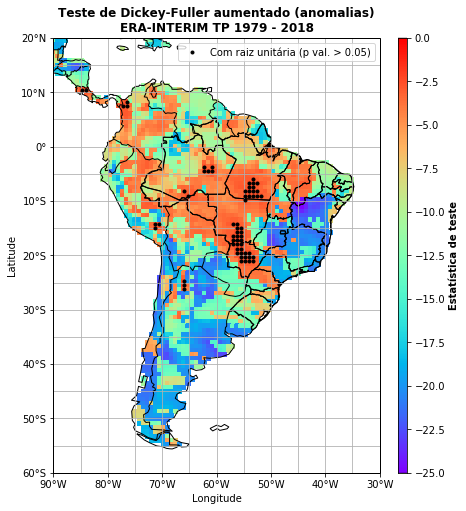

In [20]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    da = ADFs_ano.sel(stats="adf_test").where(ADFs_ano.land_mask == True)
    p = da.plot(
        ax=axis,
        vmin=-25,
        vmax=0,
        cmap=plt.cm.rainbow,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Teste de Dickey-Fuller aumentado (anomalias)\n" + \
                     "ERA-INTERIM TP 1979 - 2018", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Estatística de teste", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-25, 2.5, 2.5))

# Statistical significant.
mask = ADFs_ano.sel(stats="p_value").where(ADFs_ano.land_mask == True) > 0.05
LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

# With unit root.
axis.plot(LON[mask], LAT[mask], ".k", label="Com raiz unitária (p val. > 0.05)", 
          transform=projection)
   
# Legend.    
axis.legend();